In [4]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam, SGD
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [5]:
# checking for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
# Transforms
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),  # oglindire orizontală aleatoare a imaginilor
    transforms.ToTensor(),  # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5],  # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5, 0.5, 0.5])
])

In [7]:
# Visualization function
def visualize_data_distribution(loader):
    labels = []
    for _, label in loader.dataset:#_ e imaginea, label e eticheta imaginii
        labels.append(label)#adaug eticheta in lista labels
    plt.hist(labels, bins=len(set(labels)))#labels-lista etichetelor, bins seteaza nr de binuri din histograma, egal cu nr de clase unice (nr elem unice din labels)
   
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()  # afisare histograma

In [8]:
# Dataloader
# Paths for training, testing and validation directories
pred_path = 'C:\\Users\\adeli\\OneDrive\\Documente\\Vegetable_Images\\validation'
train_path = 'C:\\Users\\adeli\\OneDrive\\Documente\\Vegetable_Images\\train'
test_path = 'C:\\Users\\adeli\\OneDrive\\Documente\\Vegetable_Images\\test'

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformer),
    batch_size=64, shuffle=True
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformer),
    batch_size=32, shuffle=True
)

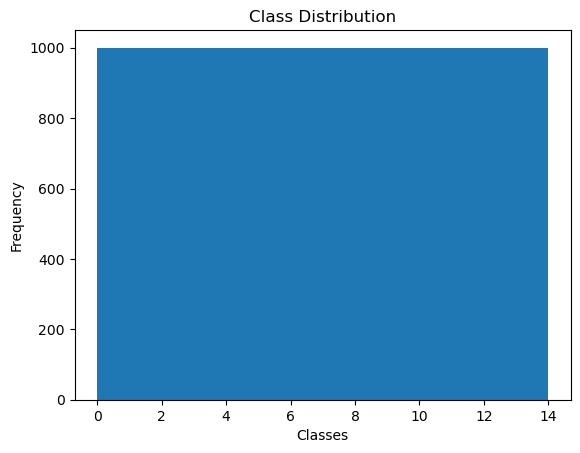

In [9]:
# Visualize data distribution
visualize_data_distribution(train_loader)

In [10]:
# Identify and sort categories
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

print(classes)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [11]:
# CNN Network
class ConvNet(nn.Module):
    def __init__(self, num_classes=15):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)#stratul de convolutie initial, cu 3 canale de intrare coresp rgb
        self.bn1 = nn.BatchNorm2d(num_features=12)#strat de normalizare, pt accelerare antrenament
        self.relu1 = nn.ReLU()#functia de activare ReLu
        self.pool = nn.MaxPool2d(kernel_size=2)#startul de pooling care reduce dimensiunea imaginilor la jumatate; cu kernel de dim 2x2
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)#al doilea strat de convolutie, cu 12 canale de intrare
        #coresp celor 12 canale de iesire ale primului strat
        self.relu2 = nn.ReLU()#functia de activare aplicata pe al doilea strat de convolutie
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)#al treilea strat de convolutie
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()#functia de activare aplicata dupa stratul de normalizare
        self.fc = nn.Linear(in_features=75 * 75 * 32, out_features=num_classes)#startul fully connected, converteste ultimul set de activari intr-o predictie
        #de clasa; intrarile sunt redimensionate intr-un vector liniar si trecute printr-o op liniara cu nr de iesiri egal cu nr de clase dorite

    #metoda defineste fluxul de date prin retea
    #intrarea este trecuta prin primul strat de convolutie, apoi prin stratul de normalizare, prin functia de activare ReLu, apoi prin stratul de pooling
    #se repeta procesul pentru celelalte doua straturi de convolutie si de normalizare
    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = output.view(-1, 32 * 75 * 75)#iesirea este redimensionata intr-un vector liniar
        output = self.fc(output)#vectorul liniar este trecut prin stratul fully connected pentru predictia finala
        return output

In [12]:
# Helper function to train the model
def train_model(model, optimizer, num_epochs, train_loader, test_loader, train_count, test_count, optimizer_name):
    loss_function = nn.CrossEntropyLoss()#definirea functiei de pierdere
    #loss_function = nn.MSELoss()
    writer = SummaryWriter(log_dir=f'runs/{optimizer_name}')#pentru scrierea informatiilor despre antrenament in directoare specifice, pt fiecare optimizator
    best_accuracy = 0.0#stocheaza cea mai buna acuratete pe setul de testare; val va fi actualizata de fiecare data cand e atinsa o noua acuratete maxima pe 
    #setul de testare
    train_losses = []#lista in care se stocheaza pierderile de antrenament la fiecare epoca
    val_accuracies = []#stocheaza acuratetea la fiecare epoca pe setul de testare
    
#antrenarea modelului
    for epoch in range(num_epochs):#se parcurg toate iteratiile de antrenament
        model.train()#modelul e comutat in modul antrenament
        train_accuracy = 0.0
        train_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):#pt fiecare lot de date de antrenament
            #datele sunt mutate pe dispozitivul de calcul dorit
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()#gradientii parametrilor sunt init cu 0
            outputs = model(images)#se calc predictiile modelului pe baza imag de intrare
            loss = loss_function(outputs, labels)#se calc val functiei de pierdere intre predictii si etichetele reale
            loss.backward()#se face propagarea inapoi pt a calcula gradientii
            optimizer.step()#se actualizeaza param modelului

            train_loss += loss.cpu().data * images.size(0)#se calc pierderea totala de antrenament pt epoca curenta
            #care e: suma pierderilor pt toate loturile de date, normalizata la dim totala a setului de date de antrenament
            _, prediction = torch.max(outputs.data, 1)
            #se calculeaza acuratetea de antrenament pt epoca curenta
            #astfel: proportia de predictii corecte fata de numarul total de exemple de antrenament
            train_accuracy += int(torch.sum(prediction == labels.data))
           

        train_accuracy = train_accuracy / train_count
        train_loss = train_loss / train_count

        train_losses.append(train_loss.item())
        writer.add_scalar('Loss/train', train_loss.item(), epoch)

        # Evaluation on testing dataset
        model.eval()#modelul e comutat in modul de evaluare
        test_accuracy = 0.0
        for i, (images, labels) in enumerate(test_loader):#pentru fiecare lot de date de testare
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            outputs = model(images)#se calc predictiile modelului pe baza imag de intrare
            _, prediction = torch.max(outputs.data, 1)
            test_accuracy += int(torch.sum(prediction == labels.data))#se calc acuratetea pe setul de testare

        test_accuracy = test_accuracy / test_count
        val_accuracies.append(test_accuracy)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)

        print(f'Epoch: {epoch} Train Loss: {train_loss} Train Accuracy: {train_accuracy} Test Accuracy: {test_accuracy}')

        #salvarea celui mai bun model
        if test_accuracy > best_accuracy:#dsaca acuratetea pe setul de testare pe epoca curenta>cea mai buna acuratetea de pana acum, modelul se salveaza
            torch.save(model.state_dict(), f'best_checkpoint_{optimizer_name}.model')
            best_accuracy = test_accuracy

    writer.close()
    return train_losses, val_accuracies#se returneaza listele care contin pierderile de antrenament si acuratetile pe setul de testare pt fiecare epoca

In [13]:
# Number of epochs
num_epochs = 10

In [14]:
#numara cate imagini sunt in seturile de antrenament si de testare
train_count = len(glob.glob(train_path + '/**/*.jpg'))
test_count = len(glob.glob(test_path + '/**/*.jpg'))

In [ ]:
# Initialize models and optimizers
model_adam = ConvNet(num_classes=15).to(device)
optimizer_adam = Adam(model_adam.parameters(), lr=0.001, weight_decay=0.0001)

model_sgd = ConvNet(num_classes=15).to(device)
optimizer_sgd = SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)

In [16]:
# Train and evaluate with Adam optimizer
train_losses_adam, val_accuracies_adam = train_model(model_adam, optimizer_adam, num_epochs, train_loader, test_loader, train_count, test_count, 'adam')


Epoch: 0 Train Loss: 7.058862209320068 Train Accuracy: 0.6235333333333334 Test Accuracy: 0.7983333333333333
Epoch: 1 Train Loss: 2.1469409465789795 Train Accuracy: 0.8284666666666667 Test Accuracy: 0.8333333333333334
Epoch: 2 Train Loss: 1.450282335281372 Train Accuracy: 0.8808 Test Accuracy: 0.8703333333333333
Epoch: 3 Train Loss: 0.976044774055481 Train Accuracy: 0.915 Test Accuracy: 0.908
Epoch: 4 Train Loss: 0.7952491641044617 Train Accuracy: 0.931 Test Accuracy: 0.8726666666666667
Epoch: 5 Train Loss: 0.6848713755607605 Train Accuracy: 0.9379333333333333 Test Accuracy: 0.884
Epoch: 6 Train Loss: 0.47119390964508057 Train Accuracy: 0.9529333333333333 Test Accuracy: 0.8363333333333334
Epoch: 7 Train Loss: 0.374555379152298 Train Accuracy: 0.9606 Test Accuracy: 0.8866666666666667
Epoch: 8 Train Loss: 0.39617228507995605 Train Accuracy: 0.9610666666666666 Test Accuracy: 0.8846666666666667
Epoch: 9 Train Loss: 0.34044963121414185 Train Accuracy: 0.9646 Test Accuracy: 0.9316666666666666

In [26]:
# Train and evaluate with SGD optimizer
train_losses_sgd, val_accuracies_sgd = train_model(model_sgd, optimizer_sgd, num_epochs, train_loader, test_loader, train_count, test_count, 'sgd')


Epoch: 0 Train Loss: 1.8232213258743286 Train Accuracy: 0.6364 Test Accuracy: 0.8186666666666667
Epoch: 1 Train Loss: 0.4628056287765503 Train Accuracy: 0.8704 Test Accuracy: 0.875
Epoch: 2 Train Loss: 0.25421538949012756 Train Accuracy: 0.9232 Test Accuracy: 0.8906666666666667
Epoch: 3 Train Loss: 0.15607701241970062 Train Accuracy: 0.9508666666666666 Test Accuracy: 0.9086666666666666
Epoch: 4 Train Loss: 0.10434140264987946 Train Accuracy: 0.9688666666666667 Test Accuracy: 0.9433333333333334
Epoch: 5 Train Loss: 0.06976091116666794 Train Accuracy: 0.9810666666666666 Test Accuracy: 0.931
Epoch: 6 Train Loss: 0.053639572113752365 Train Accuracy: 0.9844 Test Accuracy: 0.947
Epoch: 7 Train Loss: 0.03767399862408638 Train Accuracy: 0.9916666666666667 Test Accuracy: 0.952
Epoch: 8 Train Loss: 0.030230415984988213 Train Accuracy: 0.9916 Test Accuracy: 0.9476666666666667
Epoch: 9 Train Loss: 0.02488499879837036 Train Accuracy: 0.9952 Test Accuracy: 0.9486666666666667


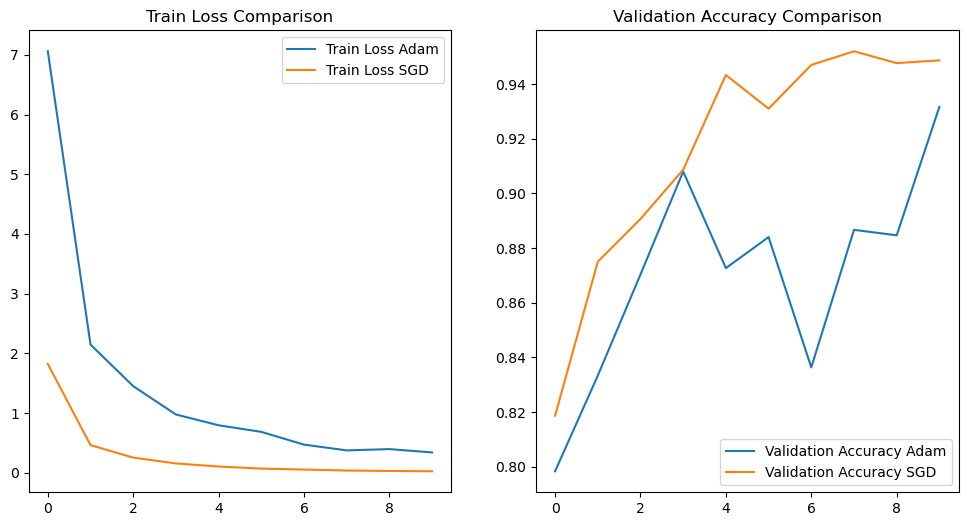

In [28]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_adam, label='Train Loss Adam')
plt.plot(train_losses_sgd, label='Train Loss SGD')
plt.legend()
plt.title('Train Loss Comparison')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_adam, label='Validation Accuracy Adam')
plt.plot(val_accuracies_sgd, label='Validation Accuracy SGD')
plt.legend()
plt.title('Validation Accuracy Comparison')

plt.show()

In [30]:
#incarca cel mai bun model salvat pentru predictii si evaluari
#se creeaza o instanta a modelului ConvNet
#se incarca param modelului; seteaza modelulin modul de evaluare
def load_best_model(optimizer_name):
    model = ConvNet(num_classes=15).to(device)
    checkpoint = torch.load(f'best_checkpoint_{optimizer_name}.model')
    model.load_state_dict(checkpoint)
    model.eval()
    return model

In [40]:
#functia de predictie
def prediction(img_path, transformer, model, classes):
    image = Image.open(img_path)#se incarca imaginea
    image_tensor = transformer(image).float()#se aplica transformarile definite (redimensionare, conversie la tensor si normalizare) 
    #si se converteste imaginea in tensor de tip float
    image_tensor = image_tensor.unsqueeze_(0)#se adauga o dimensiune suplimentara pentru a transforma tensorul intr-un batch de marime 1
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
    #se creeaza o variabila input din tensorul imaginii si se face o predictie utilizand modelul - output
    input = Variable(image_tensor)
    output = model(input)
    index = output.data.cpu().numpy().argmax()#converteste iesirea modelului in format numpy
    #se gaseste indexul cu valoarea max (predictia modelului), se obtine clasa corespunzatoare din lista de clase
    pred = classes[index]
    return pred

#definirea transformarilor
transformer_pred = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Prediction on validation images
images_path = glob.glob(pred_path + '/**/*.jpg')
pred_dict = {}

for img_path in images_path:#se tiparesc predictiile
    pred_dict[os.path.basename(img_path)] = prediction(img_path, transformer_pred, best_model_adam, classes)  

# Print predictions
for img_name, pred_class in pred_dict.items():
    print(f'{img_name}: {pred_class}')

0023.jpg: Bean
0024.jpg: Bean
0025.jpg: Bean
0027.jpg: Bean
0031.jpg: Bean
0032.jpg: Bean
0033.jpg: Bean
0038.jpg: Bean
0040.jpg: Bean
0042.jpg: Bean
0043.jpg: Bean
0044.jpg: Bean
0046.jpg: Bean
0048.jpg: Bean
0049.jpg: Bitter_Gourd
0050.jpg: Bean
0051.jpg: Bean
0052.jpg: Cucumber
0053.jpg: Cucumber
0054.jpg: Bean
0056.jpg: Bean
0057.jpg: Bean
0059.jpg: Bean
0060.jpg: Bean
0062.jpg: Bean
0163.jpg: Bean
0164.jpg: Bean
0165.jpg: Bean
0166.jpg: Bean
0167.jpg: Bean
0168.jpg: Bean
0169.jpg: Bean
0170.jpg: Bean
0171.jpg: Bean
0172.jpg: Bean
0173.jpg: Bean
0174.jpg: Bean
0175.jpg: Bean
0177.jpg: Bean
0178.jpg: Bean
0180.jpg: Cucumber
0182.jpg: Bean
0183.jpg: Bean
0185.jpg: Bean
0186.jpg: Bean
0188.jpg: Bean
0190.jpg: Bean
0192.jpg: Bean
0197.jpg: Bean
0198.jpg: Bean
0209.jpg: Bean
0210.jpg: Cabbage
0211.jpg: Bean
0213.jpg: Bean
0215.jpg: Bean
0222.jpg: Cucumber
0224.jpg: Cucumber
0228.jpg: Bean
0230.jpg: Bean
0232.jpg: Bean
0320.jpg: Bean
0321.jpg: Bean
0322.jpg: Bean
0323.jpg: Bean
0331.jpg:

In [32]:
# Confusion Matrix and Metrics Evaluation
def evaluate_model(loader, model, classes):
    test_labels = []
    test_preds = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)#trecem imaginile prin model pentru a obtine predictiile
            _, prediction = torch.max(outputs.data, 1)#alegem clasa cu cea mai mare probabilitate ca fiind predictia modelului.

            test_labels.extend(labels.cpu().numpy())#adaugam etichetele reale ale batch-ului la lista
            test_preds.extend(prediction.cpu().numpy())#adaugam predictiile modelului 

    accuracy = accuracy_score(test_labels, test_preds)#calculam acuratetea
    recall = recall_score(test_labels, test_preds, average='micro')#calculam recall
    cm = confusion_matrix(test_labels, test_preds)#calc matricea de confuzie

    return cm, accuracy, recall

In [33]:
# Evaluate the best model trained with Adam
#incarca cel mai bun model antrenat folosind optimizatorul Adam
#evalueaza performanta acestuia pe setul de date de testare folosind matricea de confuzie, acuratețea si recall
best_model_adam = load_best_model('adam')
cm_adam, acc_adam, recall_adam = evaluate_model(test_loader, best_model_adam, classes)
print(f'Adam Optimizer - Confusion Matrix:\n{cm_adam}')
print(f'Adam Optimizer - Accuracy: {acc_adam}')
print(f'Adam Optimizer - Recall: {recall_adam}')

Adam Optimizer - Confusion Matrix:
[[184   1   0   4   0   2   0   0   0   6   0   0   0   3   0]
 [  2 181   0   0   0   4   0   0   1  11   0   0   1   0   0]
 [  0   0 191   4   0   0   0   0   0   1   3   0   0   0   1]
 [  0   0  10 177   1   0   0   0   0   4   7   0   1   0   0]
 [  1   0   1   1 169  11   0   0   3   6   0   0   7   0   1]
 [  1   0   0   1   0 183   0   0   8   1   0   0   3   0   3]
 [  1   0   1   5   0   0 188   1   0   0   2   0   1   0   1]
 [  0   0   0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  2   0   0   1   0   0   0   0 181   7   1   1   2   2   3]
 [  1   0   5   6   0   0   0   0   1 184   1   0   1   0   1]
 [  0   0  13   5   0   0   0   0   0   1 181   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   1   0 198   0   0   0]
 [  0   1   0   0   1   1   3   0   0   0   0   0 194   0   0]
 [  0   0   0   0   0   0   0   1   1   0   0   2   0 196   0]
 [  7   0   0   1   1   0   0   6   1   1   0   0   5   4 174]]
Adam Optimizer - Ac

In [35]:
# Evaluate the best model trained with SGD
best_model_sgd = load_best_model('sgd')
cm_sgd, acc_sgd, recall_sgd = evaluate_model(test_loader, best_model_sgd, classes)
print(f'SGD Optimizer - Confusion Matrix:\n{cm_sgd}')
print(f'SGD Optimizer - Accuracy: {acc_sgd}')
print(f'SGD Optimizer - Recall: {recall_sgd}')

SGD Optimizer - Confusion Matrix:
[[187   6   0   1   0   0   0   0   6   0   0   0   0   0   0]
 [  2 194   0   0   0   1   0   0   2   0   0   0   1   0   0]
 [  0   0 190   0   0   0   1   0   2   1   5   0   0   0   1]
 [  1   0   3 182   1   3   0   0   2   1   5   0   1   0   1]
 [  3   0   1   0 183   3   0   0   6   1   0   0   2   1   0]
 [  2   0   0   2   1 186   0   0   4   2   0   0   2   0   1]
 [  0   0   1   1   0   0 196   0   0   0   0   1   0   0   1]
 [  0   0   0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  2   0   0   3   2   0   0   0 187   1   1   0   2   0   2]
 [  0   0   1   4   0   2   0   0   2 190   1   0   0   0   0]
 [  0   0   2   2   0   0   0   0   2   0 194   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 198   0   2   0]
 [  0   0   0   1   3   2   0   0   0   0   0   0 194   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   1   0 197   0]
 [  6   0   0   0   2   2   1   1   7   0   1   1   3   2 174]]
SGD Optimizer - Accu

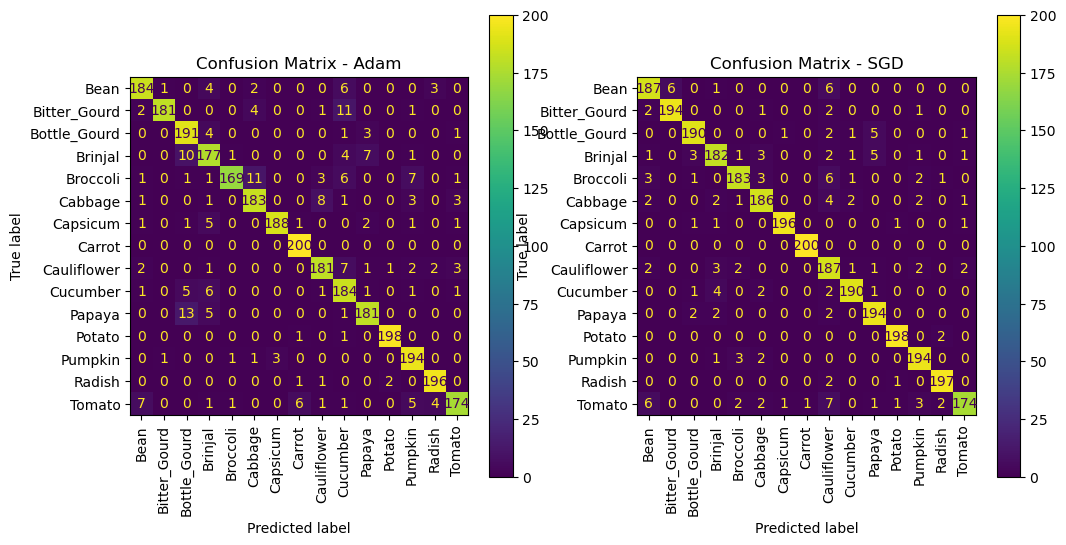

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_adam, display_labels=classes).plot(ax=ax[0], xticks_rotation='vertical')
ax[0].set_title('Confusion Matrix - Adam')

ConfusionMatrixDisplay(cm_sgd, display_labels=classes).plot(ax=ax[1], xticks_rotation='vertical')
ax[1].set_title('Confusion Matrix - SGD')

plt.show()

In [49]:
from sklearn.model_selection import KFold

# Define the number of splits for cross-validation
num_splits = 5  #numarul de subdiviziuni ale setului de date pentru a fi utilizate in validarea incrucisata

# Initialize KFold
kf = KFold(n_splits=num_splits, shuffle=True)

#se creeaza liste pentru a stoca scorurile de acuratete si recall pentru fiecare fold
accuracy_scores = []
recall_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(train_loader.dataset)):
    print(f'Fold {fold + 1}:')
    #pentru fiecare fold, setul de date este impărtit intr-un subset de antrenare si un subset de testare folosind indicii returnati de kf.split()
    train_subset = torch.utils.data.Subset(train_loader.dataset, train_index)
    test_subset = torch.utils.data.Subset(train_loader.dataset, test_index)

    train_loader_fold = DataLoader(train_subset, batch_size=64, shuffle=True)
    test_loader_fold = DataLoader(test_subset, batch_size=32, shuffle=False)

    # Initialize models and optimizers for this fold
    model_adam_fold = ConvNet(num_classes=15).to(device)
    optimizer_adam_fold = Adam(model_adam_fold.parameters(), lr=0.001, weight_decay=0.0001)

    model_sgd_fold = ConvNet(num_classes=15).to(device)
    optimizer_sgd_fold = SGD(model_sgd_fold.parameters(), lr=0.001, momentum=0.9)

    # Train and evaluate with Adam optimizer for this fold
    train_losses_adam_fold, val_accuracies_adam_fold = train_model(model_adam_fold, optimizer_adam_fold, num_epochs, train_loader_fold, test_loader_fold, len(train_index), len(test_index), f'adam_fold{fold}')

    # Train and evaluate with SGD optimizer for this fold
    train_losses_sgd_fold, val_accuracies_sgd_fold = train_model(model_sgd_fold, optimizer_sgd_fold, num_epochs, train_loader_fold, test_loader_fold, len(train_index), len(test_index), f'sgd_fold{fold}')

    # Evaluate the best model trained with Adam optimizer for this fold
    best_model_adam_fold = load_best_model(f'adam_fold{fold}')
    cm_adam_fold, acc_adam_fold, recall_adam_fold = evaluate_model(test_loader_fold, best_model_adam_fold, classes)
    print(f'Adam Optimizer - Confusion Matrix (Fold {fold + 1}):\n{cm_adam_fold}')
    print(f'Adam Optimizer - Accuracy (Fold {fold + 1}): {acc_adam_fold}')
    print(f'Adam Optimizer - Recall (Fold {fold + 1}): {recall_adam_fold}')
    #se calculeaza si se afiseaza scorurile medii de acuratete si recall pentru toate foldurile
    accuracy_scores.append(acc_adam_fold)
    recall_scores.append(recall_adam_fold)

    # Evaluate the best model trained with SGD optimizer for this fold
    best_model_sgd_fold = load_best_model(f'sgd_fold{fold}')
    cm_sgd_fold, acc_sgd_fold, recall_sgd_fold = evaluate_model(test_loader_fold, best_model_sgd_fold, classes)
    print(f'SGD Optimizer - Confusion Matrix (Fold {fold + 1}):\n{cm_sgd_fold}')
    print(f'SGD Optimizer - Accuracy (Fold {fold + 1}): {acc_sgd_fold}')
    print(f'SGD Optimizer - Recall (Fold {fold + 1}): {recall_sgd_fold}')
    accuracy_scores.append(acc_sgd_fold)
    recall_scores.append(recall_sgd_fold)

#scorurile medii pentru a evalua performanta generala a modelelor
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)
print(f'Average Accuracy across all folds: {avg_accuracy}')
print(f'Average Recall across all folds: {avg_recall}')


Fold 1:
Epoch: 0 Train Loss: 8.397734642028809 Train Accuracy: 0.5825833333333333 Test Accuracy: 0.6923333333333334
Epoch: 1 Train Loss: 2.254023551940918 Train Accuracy: 0.80925 Test Accuracy: 0.8396666666666667
Epoch: 2 Train Loss: 1.420755386352539 Train Accuracy: 0.869 Test Accuracy: 0.8303333333333334
Epoch: 3 Train Loss: 0.8500391244888306 Train Accuracy: 0.9113333333333333 Test Accuracy: 0.857
Epoch: 4 Train Loss: 0.7374067306518555 Train Accuracy: 0.92675 Test Accuracy: 0.8986666666666666
Epoch: 5 Train Loss: 0.9623419642448425 Train Accuracy: 0.9193333333333333 Test Accuracy: 0.8673333333333333
Epoch: 6 Train Loss: 0.5429380536079407 Train Accuracy: 0.9458333333333333 Test Accuracy: 0.904
Epoch: 7 Train Loss: 0.34972354769706726 Train Accuracy: 0.9605 Test Accuracy: 0.928
Epoch: 8 Train Loss: 0.41089555621147156 Train Accuracy: 0.9578333333333333 Test Accuracy: 0.916
Epoch: 9 Train Loss: 0.2987704575061798 Train Accuracy: 0.9655833333333333 Test Accuracy: 0.9066666666666666
Ep

KeyboardInterrupt: 